# Task 1

The purpose of this task is to classify the demand for bikes on a specific day using predefined labels. The first stage of this will be to find appropriate values to use for the labels.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in the data
train_data = pd.read_csv("./data/preprocessed_data/train.csv")

For the dataset for this task, we need data about the day, but not about individual stations. There should be one entry for each morning and afternoon, together with the weather data or other features for the whole day.

In [3]:
# Keeping the feature data for each day
day_data_cols = ['year', 'month', 'day', 'weekday', 'isHoliday', 'isWeekend', 'mean_temperature', 'total_precipitation']
day_data = train_data[day_data_cols].drop_duplicates(subset=day_data_cols, keep='first')

# Grouping the ride counts for each am and pm
train_new = train_data[['year', 'month', 'day', 'am_pm', 'rides_count']].groupby(['year', 'month', 'day', 'am_pm'], as_index=False)['rides_count'].sum()
train_new = train_new.merge(day_data, how='left', on=['year', 'month', 'day'])

train_new.head()

,year,month,day,am_pm,rides_count,weekday,isHoliday,isWeekend,mean_temperature,total_precipitation
0,2014,4,15,False,742,1,False,False,5.6,9.0
1,2014,4,15,True,835,1,False,False,5.6,9.0
2,2014,4,16,False,2462,2,False,False,-3.4,0.0
3,2014,4,16,True,718,2,False,False,-3.4,0.0
4,2014,4,17,False,4178,3,False,False,2.4,0.0


Now this data has been created, want to examine the distribution with some plots. This should give ideas for the labels to use for categories of ride counts.

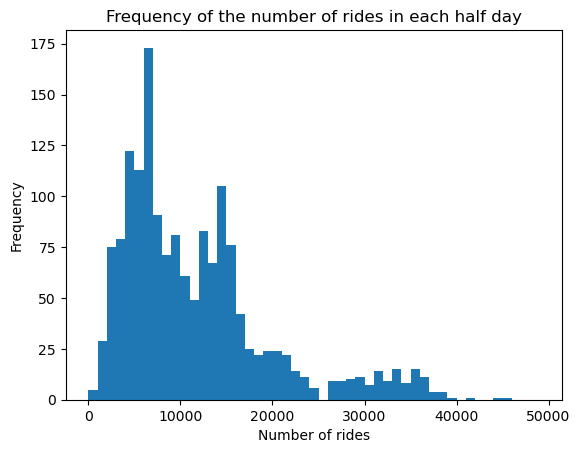

In [4]:
def dist_plot():
    plt.hist(train_new['rides_count'], bins=range(0,50000, 1000))

    plt.xlabel('Number of rides')
    plt.ylabel('Frequency')

dist_plot()
plt.title('Frequency of the number of rides in each half day')
plt.show()

It will be interesting to try different numbers of labels. For now, will create two versions. Three labels (low, medium and high) and five labels (very low, low, medium, high, very high). These will be implemented using numeric values for easier use later. These will be chosen by evenly dividing the data.

In [5]:
all_counts = list(train_new['rides_count'])
all_counts.sort()

# Thresholds for split into 3
label3_split = []
for i in range(1,3):
    label3 = all_counts[round(i*len(all_counts)/3)]
    label3_split.append(label3)

#Thresholds for split into 5
label5_split = []
for i in range(1,5):
    label5 = all_counts[round(i*len(all_counts)/5)]
    label5_split.append(label5)
    
print(label3_split, label5_split)

[6656, 13611] [5041, 7317, 12097, 16004]


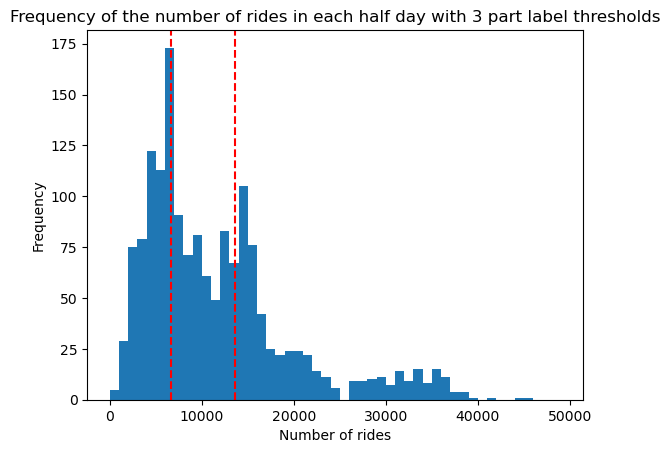

In [6]:
dist_plot()
for i in label3_split:
    plt.axvline(x=i, color='red', linestyle='dashed')
plt.title('Frequency of the number of rides in each half day with 3 part label thresholds')
plt.show()

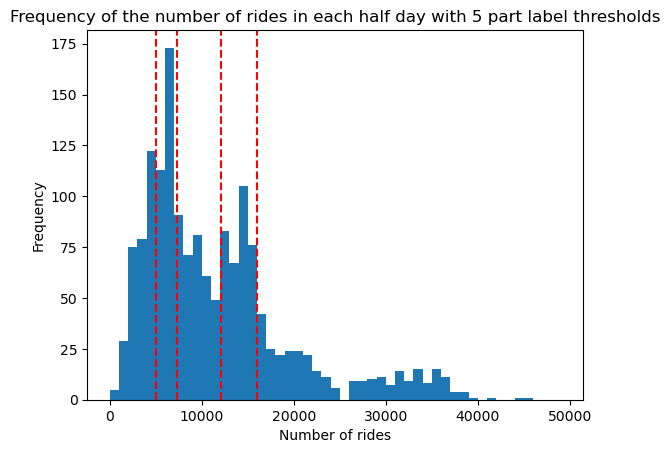

In [7]:
dist_plot()
for i in label5_split:
    plt.axvline(x=i, color='red', linestyle='dashed')
plt.title('Frequency of the number of rides in each half day with 5 part label thresholds')
plt.show()

The data table should now have values added in for these labels.

In [8]:
train_new['label3'] = np.select([train_new['rides_count']<label3_split[0],
                                 train_new['rides_count'].between(label3_split[0],label3_split[1])],
                                [1,2],3)
train_new['label5'] = np.select([train_new['rides_count']<label5_split[0],
                                 train_new['rides_count'].between(label5_split[0],label5_split[1]),
                                 train_new['rides_count'].between(label5_split[1],label5_split[2]),
                                 train_new['rides_count'].between(label5_split[2],label5_split[3])],
                                [1,2,3,4],5)

train_new.head()

,year,month,day,am_pm,rides_count,weekday,isHoliday,isWeekend,mean_temperature,total_precipitation,label3,label5
0,2014,4,15,False,742,1,False,False,5.6,9.0,1,1
1,2014,4,15,True,835,1,False,False,5.6,9.0,1,1
2,2014,4,16,False,2462,2,False,False,-3.4,0.0,1,1
3,2014,4,16,True,718,2,False,False,-3.4,0.0,1,1
4,2014,4,17,False,4178,3,False,False,2.4,0.0,1,1
